In [1]:
from collections import OrderedDict
import torch
import torch.optim as optim
from torch import nn as nn

In [2]:
# Input and output vectors are given. 
inp = [ 0.7300, -1.0400, -1.2300,  1.6700, -0.6300,  1.4300, -0.8400,  0.1500,
         -2.3000,  3.1000, -1.4500, -1.8100,  1.8700, -0.1100, -0.2800,  1.1200,
         -0.4200,  2.8900]
out = [ 1.43,  10.1,  8.3,  1.03,  10.21, -0.1,  8.92,  5.1,
         -7.53, 34.72,  7.61,  3.2,  2.19,  7.15,  7.69, -0.18,
          8.81, 23.1]

In [12]:
#Prepare the training and validation datasets: 80% training, 20% validation
t_in = torch.Tensor(inp).unsqueeze(1)
t_out = torch.Tensor(out).unsqueeze(1)

samples_num = t_in.shape[0]
n_val = int(0.2 * samples_num)

shuffled_indices = torch.randperm(samples_num)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

train_t_in = t_in[train_indices]
train_t_out = t_out[train_indices]
val_t_in = t_in[val_indices]
val_t_out = t_out[val_indices]

train_t_in.shape, train_t_out.shape, val_t_in.shape, val_t_out.shape

(torch.Size([15, 1]),
 torch.Size([15, 1]),
 torch.Size([3, 1]),
 torch.Size([3, 1]))

In [13]:
#Create a NN that consists of:
# a linear layer of input size 1 and output size 15, followed by hyperbolic tangent as its activation function
# a linear layer of input size 15 and output size 23, followed by hyperbolic tangent as its activation function
# a linear layer of input size 23 and output size 1
layer1 = nn.Linear(1,15)
layer2 = nn.Linear(15, 23)
layer3 = nn.Linear(23, 1)


seq_model = nn.Sequential(OrderedDict([
    ('Layer 1', layer1),
    ('Hidden Activation', nn.Tanh()),
    ('Layer 2', layer2),
    ('Hidden Activation', nn.Tanh()),
    ('Layer 3', layer3)
]))


# Write a little script that shows the number of parameters in each layer.
# Based on the output of this script, report as a comment in your code how many weights and biases exist in each layer.
i = 1
for layer in seq_model:
    if isinstance(layer, torch.nn.modules.linear.Linear):
        print("------ Linear Layer", i, "------")
        print("\tIn features:",layer.in_features)
        print("\tOut features:", layer.out_features)
        print("\tBias:",layer.bias.shape)
        i+=1
    else:
        print("------ Activation Layer ------")
        print(layer.type)
    print()
    

for name, param in seq_model.named_parameters():
    print(name, "\t", param.shape, end="\n")
    

# Next, define the training function that receives training and validation datasets, along with a model, loss function, 
# optimizer, and number of epochs. The function must use the model's own parameter handling and the the input loss function
# to automatically calculate the gradient of the loss wrt parameters (autograd), and use optimizer to update the parameters 
# and zero the gradients. 

# t_u = in
# t_c = out
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 10000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
        


------ Linear Layer 1 ------
	In features: 1
	Out features: 15
	Bias: torch.Size([15])

------ Activation Layer ------
<bound method Module.type of Tanh()>

------ Linear Layer 2 ------
	In features: 15
	Out features: 23
	Bias: torch.Size([23])

------ Linear Layer 3 ------
	In features: 23
	Out features: 1
	Bias: torch.Size([1])

Layer 1.weight 	 torch.Size([15, 1])
Layer 1.bias 	 torch.Size([15])
Layer 2.weight 	 torch.Size([23, 15])
Layer 2.bias 	 torch.Size([23])
Layer 3.weight 	 torch.Size([1, 23])
Layer 3.bias 	 torch.Size([1])


In [14]:
# Train your NN with built-in mean square error loss function and SGD optimizer. 
# Try different learning rates and number of epochs improve the results.
# t_u_train = t_in_train
# t_u_val

import torch.optim as optim

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

model = training_loop(
    n_epochs = 100000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_in,
    t_u_val = val_t_in,
    t_c_train = train_t_out,
    t_c_val = val_t_out
)

Epoch 1, Training loss 147.1999, Validation loss 75.0468
Epoch 10000, Training loss 0.3438, Validation loss 7.6638
Epoch 20000, Training loss 0.1669, Validation loss 4.6518
Epoch 30000, Training loss 0.1230, Validation loss 3.4557
Epoch 40000, Training loss 0.1096, Validation loss 2.9361
Epoch 50000, Training loss 0.1047, Validation loss 2.6200
Epoch 60000, Training loss 0.1023, Validation loss 2.3902
Epoch 70000, Training loss 0.1007, Validation loss 2.2109
Epoch 80000, Training loss 0.0995, Validation loss 2.0653
Epoch 90000, Training loss 0.0987, Validation loss 1.9440
Epoch 100000, Training loss 0.0980, Validation loss 1.8404


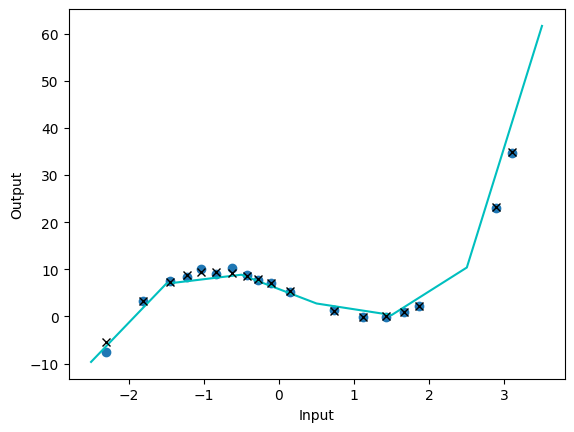

In [17]:
# Plot the trained function.
from matplotlib import pyplot as plt

t_range = torch.arange(-2.5, 4.5).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Input")
plt.ylabel("Output")
plt.plot(t_in.numpy(), t_out.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
plt.plot(t_in.numpy(), seq_model(t_in).detach().numpy(), 'kx')